### Imports

In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import tensorflow as tf

### Helper functions

In [2]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

### Load the text files

In [3]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

## Kelvin's Part

### Preprocessing

In [4]:
# Set stopwords
nltk.download("stopwords", quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords.update("i")

# Declare Emojis
emojis = [
    "😊",
    "😂",
    "😭",
    "😍",
    "😘",
    "😁",
    "😩",
    "😏",
    "😉",
    "😎",
    "😢",
    "😅",
    "😱",
    "😆",
    "😋",
    "😷",
    "😔",
    "😒",
    "😡",
    "😪",
    "😤",
    "😝",
    "😓",
    "😖",
    "😣",
    "😞",
    "😐",
    "😕",
    "😫",
    "😨",
    "😌",
    "😜",
    "😑",
    "😬",
    "😈",
    "😯",
    "😳",
    "😇",
    "😷",
    "😴",
    "😲",
    "😵",
    "😦",
    "😢",
    "😮",
    "😟",
    "😥",
    "😧",
    "😰",
    "😭",
    "😓",
    "😩",
    "😿",
    "😾",
    "🙀",
    "🙅",
    "🙆",
    "🙇",
    "🙈",
    "🙉",
    "🙊",
    "🙋",
    "🙌",
    "🙍",
    "🙎",
    "🙏",
    ":)",
    ":(",
]

# Declare a dict of emojis and their corresponding sentiment
# 0: Negative; 1: Neutral; 2: Positive
emoji_dict = {
    "😊": 2,
    "😂": 2,
    "😭": 0,
    "😍": 2,
    "😘": 2,
    "😁": 2,
    "😩": 0,
    "😏": 2,
    "😉": 2,
    "😎": 2,
    "😢": 0,
    "😅": 2,
    "😱": 0,
    "😆": 2,
    "😋": 2,
    "😷": 0,
    "😔": 0,
    "😒": 0,
    "😡": 0,
    "😪": 0,
    "😤": 0,
    "😝": 2,
    "😓": 0,
    "😖": 0,
    "😣": 0,
    "😞": 0,
    "😐": 1,
    "😕": 0,
    "😫": 0,
    "😨": 0,
    "😌": 2,
    "😜": 2,
    "😑": 1,
    "😬": 0,
    "😈": 0,
    "😯": 0,
    "😳": 0,
    "😇": 2,
    "😷": 0,
    "😴": 0,
    "😲": 0,
    "😵": 0,
    "😦": 0,
    "😢": 0,
    "😮": 0,
    "😟": 0,
    "😥": 0,
    "😧": 0,
    "😰": 0,
    "😭": 0,
    "😓": 0,
    "😩": 0,
    "😿": 0,
    "😾": 0,
    "🙀": 0,
    "🙅": 0,
    "🙆": 0,
    "🙇": 0,
    "🙈": 0,
    "🙉": 0,
    "🙊": 0,
    "🙋": 0,
    "🙌": 0,
    "🙍": 0,
    "🙎": 0,
    "🙏": 0,
    ":)": 2,
    ":(": 0,
}

### Functions

In [5]:
def text_processing(text: list[str]) -> list[list[str]]:
    """
    Process text data:
    - Remove '@user'
    - Replace emojis with their corresponding sentiment.
    - Normalize the text.
    - Tokenize the text.
    - Lowercase the text.
    - Remove stop words.
    - Remove punctuation.
    - Keep emojis.
    - Remove numbers.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[list[str]]: A list of list of processed text data.
    """
    processed_text = []
    for line in text:
        # Remove '@user'
        line = line.replace("@user", "")
        # Replace emojis with their corresponding sentiment
        line = replace_emojis(line)
        # Normalize the text using WordNetLemmatizer and tokenize the text
        lemmatizer = WordNetLemmatizer()
        tokens = nltk.word_tokenize(line)
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Lowercase the text
        tokens = [word.lower() for word in tokens]
        # Remove stop words
        tokens = [word for word in tokens if word not in stopwords]
        # Remove punctuation but keep emojis
        tokens = [word for word in tokens if word.isalnum() or word in emojis]
        # Remove numbers
        tokens = [word for word in tokens if not word.isnumeric()]
        processed_text.append(tokens)

    return processed_text


def vectorize_text(
    input: list[list[str]], vocabulary: list[str]
) -> np.ndarray[np.ndarray[float]]:
    """
    Vectorize the text data.

    Args:
        input: list[list[str]]: A list of list of text data.
        vocabulary: list[str]: The list of 1000 most common words.

    Returns:
        np.ndarray[np.ndarray[float]]: A numpy array of vectorized text data.
    """
    vectorized_text = np.zeros((len(input), len(vocabulary)))
    for i, line in enumerate(input):
        for word in line:
            if word in vocabulary:
                vectorized_text[i, vocabulary.index(word)] += 1
    return vectorized_text


def map_emoji_sentiment(input: int) -> str:
    """
    Map the emoji sentiment to a string.

    Args:
        input: int: The emoji sentiment.

    Returns:
        str: The string sentiment.
    """
    if input == 0:
        return "negative"
    elif input == 1:
        return "neutral"
    elif input == 2:
        return "positive"
    else:
        return "neutral"


def replace_emojis(input: str) -> str:
    """
    Replace emojis with their corresponding sentiment.
    If the emoji is 0, replace it with 'negative'.
    If the emoji is 1, replace it with 'neutral'.
    If the emoji is 2, replace it with 'positive'.
    If the emoji is not in the emoji_dict, replace it with 'neutral'.

    Args:
        input: str: The input text data.

    Returns:
        str: The text data with emojis replaced with their corresponding sentiment.
    """
    for emoji in emojis:
        if emoji in input:
            input = input.replace(emoji, map_emoji_sentiment(emoji_dict[emoji]))
    return input

### Process the text data

In [6]:
# Process all text data
train_text: list[list[str]] = text_processing(train_text)
test_text: list[list[str]] = text_processing(test_text)
validation_text: list[list[str]] = text_processing(validation_text)

In [8]:
# Find index of lists in train_text and validation_text that are empty
empty_index_train = [i for i, x in enumerate(train_text) if not x]
empty_index_validation = [i for i, x in enumerate(validation_text) if not x]

# Remove empty lists from train_text and validation_text, and corresponding labels
train_text = [
    train_text[i] for i in range(len(train_text)) if i not in empty_index_train
]
train_label = [
    train_label[i] for i in range(len(train_label)) if i not in empty_index_train
]
validation_text = [
    validation_text[i]
    for i in range(len(validation_text))
    if i not in empty_index_validation
]
validation_label = [
    validation_label[i]
    for i in range(len(validation_label))
    if i not in empty_index_validation
]

In [9]:
# Find the 1000 most common words in the training data
word_frequency: dict[str, int] = {}
for line in train_text:
    for word in line:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1

vocabulary: list[str] = [
    word
    for word, _ in sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[
        :1000
    ]
]

In [10]:
# Convert the labels to integers
train_label: list[int] = [int(label) for label in train_label]
test_label: list[int] = [int(label) for label in test_label]
validation_label: list[int] = [int(label) for label in validation_label]

### Vectorize the input

In [11]:
# Vectorize the text data
train_vectorized: np.ndarray[np.ndarray[float]] = vectorize_text(train_text, vocabulary)
test_vectorized: np.ndarray[np.ndarray[float]] = vectorize_text(test_text, vocabulary)
validation_vectorized: np.ndarray[np.ndarray[float]] = vectorize_text(
    validation_text, vocabulary
)

In [12]:
# Find the entries with all zeros in the vectorized data
zero_index_train: np.ndarray[int] = np.where(~train_vectorized.any(axis=1))[0]
zero_index_validation: np.ndarray[int] = np.where(~validation_vectorized.any(axis=1))[0]

print("Original training data size:", len(train_vectorized))
print("Original validation data size:", len(validation_vectorized))

# Remove entries with all zeros in the vectorized data, and corresponding labels
train_vectorized: np.ndarray[np.ndarray[float]] = np.delete(
    train_vectorized, zero_index_train, axis=0
)
train_label: list[int] = [
    train_label[i] for i in range(len(train_label)) if i not in zero_index_train
]
validation_vectorized: np.ndarray[np.ndarray[float]] = np.delete(
    validation_vectorized, zero_index_validation, axis=0
)
validation_label: list[int] = [
    validation_label[i]
    for i in range(len(validation_label))
    if i not in zero_index_validation
]

print("Processed training data size:", len(train_vectorized))
print("Processed validation data size:", len(validation_vectorized))

Original training data size: 45615
Original validation data size: 2000
Processed training data size: 45602
Processed validation data size: 2000


In [13]:
print("Training data shape:", train_vectorized.shape)

Training data shape: (45602, 1000)


### CNN

In [14]:
# Convert the labels to one-hot encoding
train_label_one_hot: np.ndarray[np.ndarray[float]] = tf.one_hot(train_label, 3)
validation_label_one_hot: np.ndarray[np.ndarray[float]] = tf.one_hot(
    validation_label, 3
)

# Define the model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(1024, input_shape=(1000,), activation="sigmoid"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation="sigmoid"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation="sigmoid"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_vectorized,
    train_label_one_hot,
    validation_data=(validation_vectorized, validation_label_one_hot),
    epochs=10,
    batch_size=32,
)

Epoch 1/10


c:\Users\Kelvin\anaconda3\envs\CU_ML_CNN\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1426/1426 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4398 - loss: 1.0594 - val_accuracy: 0.5945 - val_loss: 0.8992
Epoch 2/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5866 - loss: 0.9007 - val_accuracy: 0.6175 - val_loss: 0.8439
Epoch 3/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6144 - loss: 0.8472 - val_accuracy: 0.6415 - val_loss: 0.8169
Epoch 4/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6269 - loss: 0.8189 - val_accuracy: 0.6460 - val_loss: 0.8026
Epoch 5/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6253 - loss: 0.8149 - val_accuracy: 0.6465 - val_loss: 0.8021
Epoch 6/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6347 - loss: 0.8082 - val_accuracy: 0.6475 - val_loss: 0.8040
Epoch 7/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6421 - loss: 0.7917 - val_accuracy: 0.6405 - val_loss: 0.8041
Epoch 8/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6444 - loss: 0.7912 - val_accura

In [15]:
# Evaluate the model
test_label_one_hot: np.ndarray[np.ndarray[float]] = tf.one_hot(test_label, 3)
test_loss, test_accuracy = model.evaluate(test_vectorized, test_label_one_hot)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5602 - loss: 0.9321
Test loss: 0.9323558211326599
Test accuracy: 0.5610550045967102


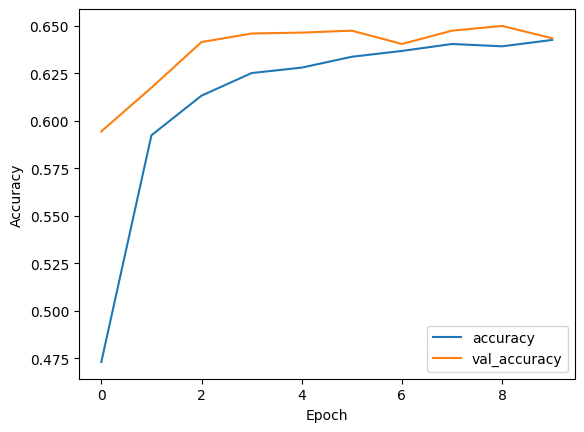

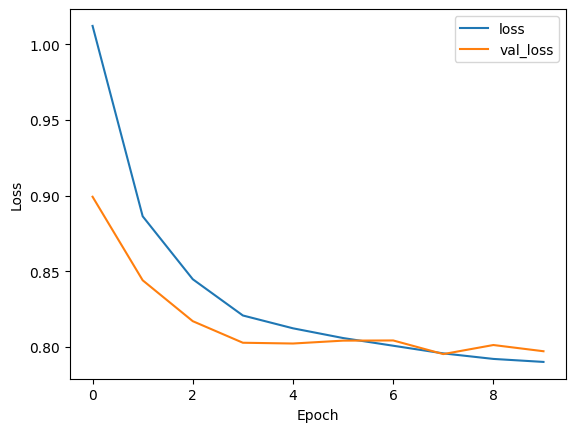

In [16]:
# Plot the training and validation accuracy
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()